In [4]:
#pydata analysis environment
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pickle
import geopandas as gpd
import rioxarray as rio
import matplotlib.ticker as mticker
import calendar
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import mapping
from mhm_dataprocessing import *

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'


#### mHM output validation

In [23]:
src_dir = r"W:/VUB/_main_research/mHM/model_validation_data/waterinfo_csv/waterinfo_timeseries"
station_locations = pd.read_csv(src_dir + "/mhm_flow_stations_coordinates.csv")
sim_flow_mhm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States.nc")
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")
#Gleam root zone soil moisture
gleam_rzsm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\gleam_EUR_SMrz_EAS_2000_2023.nc")

#MODIS 8day Evapotranspiration
modis_et = xr.open_dataset(r"W:\VUB\_main_research\mHM\model_validation_data\modis_et\BE_MODIS_ET_20002023.nc")

#shapefile study area
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")

### Modis data

In [14]:
#remove no data values in modis
min_value = 30000
max_value = 32767
modis_data = modis_et['ET']

modis_data_et = modis_data.where((modis_data < min_value) | (modis_data > max_value), np.nan)

# Update the dataset with the modified variable
#modis_data['ET'] = modis_data

In [15]:
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= mhm_fluxes[variables].resample(time='ME').mean()

#### Simulated data

In [16]:
be_clipped = clip_to_region(be_shp,sim_flow_mhm)

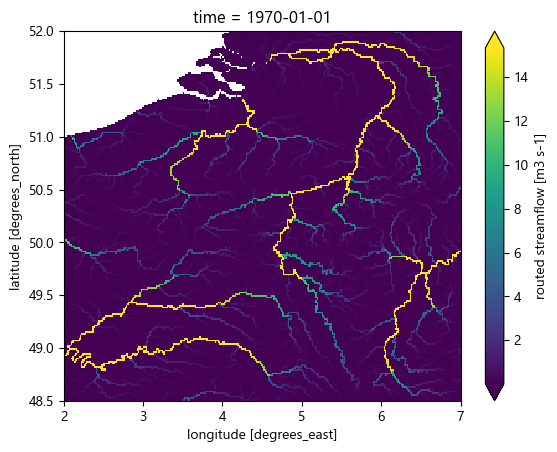

In [17]:
sim_flow_mhm['Qrouted'][0,:,:].plot(robust=True)

<GeoAxes: title={'center': 'time = 1970-01-01'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

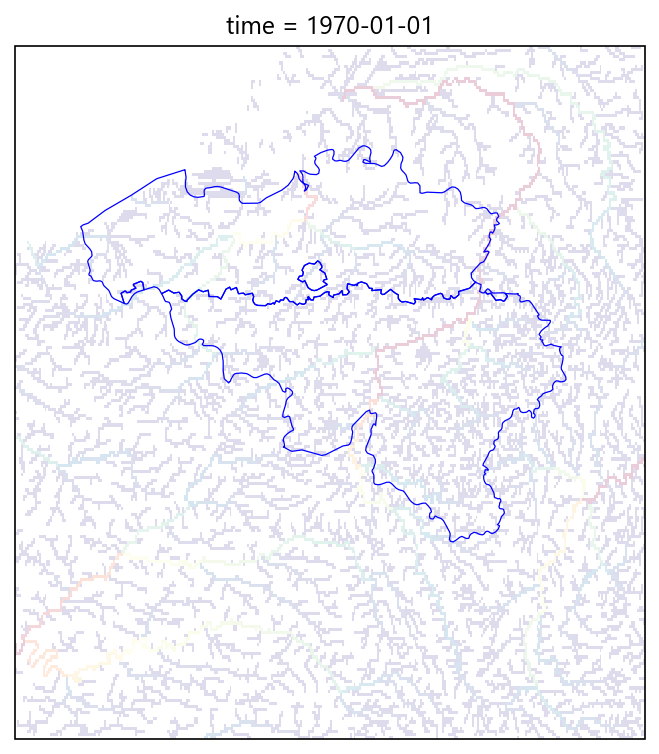

In [18]:
#sim_flow_mhm_calib['Qrouted'][0].plot(cmap='Spectral_r',robust=True)

# Assuming sim_flow_mhm_calib['Qrouted'][0] is your data array and it's correctly set up with coordinates
# Plot data where Qrouted is greater than 20
mRM_clipped = sim_flow_mhm['Qrouted'][0].where(sim_flow_mhm['Qrouted'][0] > 0.05)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6), dpi=150)

# Plot the data
im = mRM_clipped.plot(
    ax=ax,
    cmap='Spectral_r',
    transform=ccrs.PlateCarree(),
    robust=True,
    alpha=0.2,  # Set transparency to 0.8
    add_colorbar=False  # Disable the default colorbar
)
# Add shapefile boundaries
be_shp.boundary.plot(ax=ax, edgecolor='b', linewidth=0.6)

### Extract multistation data

In [25]:
#extracting the simulated flow
eval_station = {}

for station, row in station_locations.iterrows():
    station = row.stat_name
    mhm_flow = sim_flow_mhm['Qrouted'].sel(lat = row.lat, lon = row.lon, method = 'nearest') 
    sim_flow = mhm_flow.to_dataframe().drop(columns=['lat', 'lon'])

    observed = pd.read_csv(src_dir + f"/{station}_Q.csv", parse_dates=True, index_col=0, dayfirst=True)
    observed[observed == -9999] = np.nan

    #fill blanks in observed data with nan
    observed = observed.resample('D').mean()

    obs_sim = pd.concat([observed, sim_flow], axis=1)
    obs_sim.columns = ['observed', 'simulated']
    obs_sim.dropna(inplace=True)
    obs_sim = obs_sim.resample('D').mean()

    eval_station[station] = obs_sim


### Goodness of Fit

In [26]:
def nse(observed, simulated):
    return np.round(1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)),2)
def pbias(observed, simulated):
    return 100* np.round(np.sum(observed - simulated) / np.sum(observed),3)
def kge(observed, simulated):
    return np.round(1 - np.sqrt((np.corrcoef(observed, simulated)[0, 1] - 1) ** 2 + (np.std(simulated, ddof=1) / np.std(observed, ddof=1) - 1) ** 2 + (np.mean(simulated) / np.mean(observed) - 1) ** 2),2)

In [ ]:
#statistics for each station validation period up to 2000
#calibrated period 2000:

kge_values_cal = {}
nse_values_cal = {}
pbias_values_cal = {}

#check is minimum index is at least 5 years before 2010
for station, data in eval_station.items():
    if (data.index.max()) > pd.to_datetime('2010-01-01'):
        kge_values_cal[station] = kge(data['observed']['2010':], data['simulated']['2010':])
        nse_values_cal[station] = nse(data['observed']['2010':], data['simulated']['2010':])
        pbias_values_cal[station] = pbias(data['observed']['2010':], data['simulated']['2010':])
    else:
        kge_values_cal[station] = None
        nse_values_cal[station] = None
        pbias_values_cal[station] = None

#statistics for each station validation period up to 2000
#calibrated period :2000

kge_values_val = {}
nse_values_val = {}
pbias_values_val = {}

for station, data in eval_station.items():
    kge_values_val[station] = kge(data['observed'][:'2010'], data['simulated'][:'2010'])
    nse_values_val[station] = nse(data['observed'][:'2010'], data['simulated'][:'2010'])
    pbias_values_val[station] = pbias(data['observed'][:'2010'], data['simulated'][:'2010'])


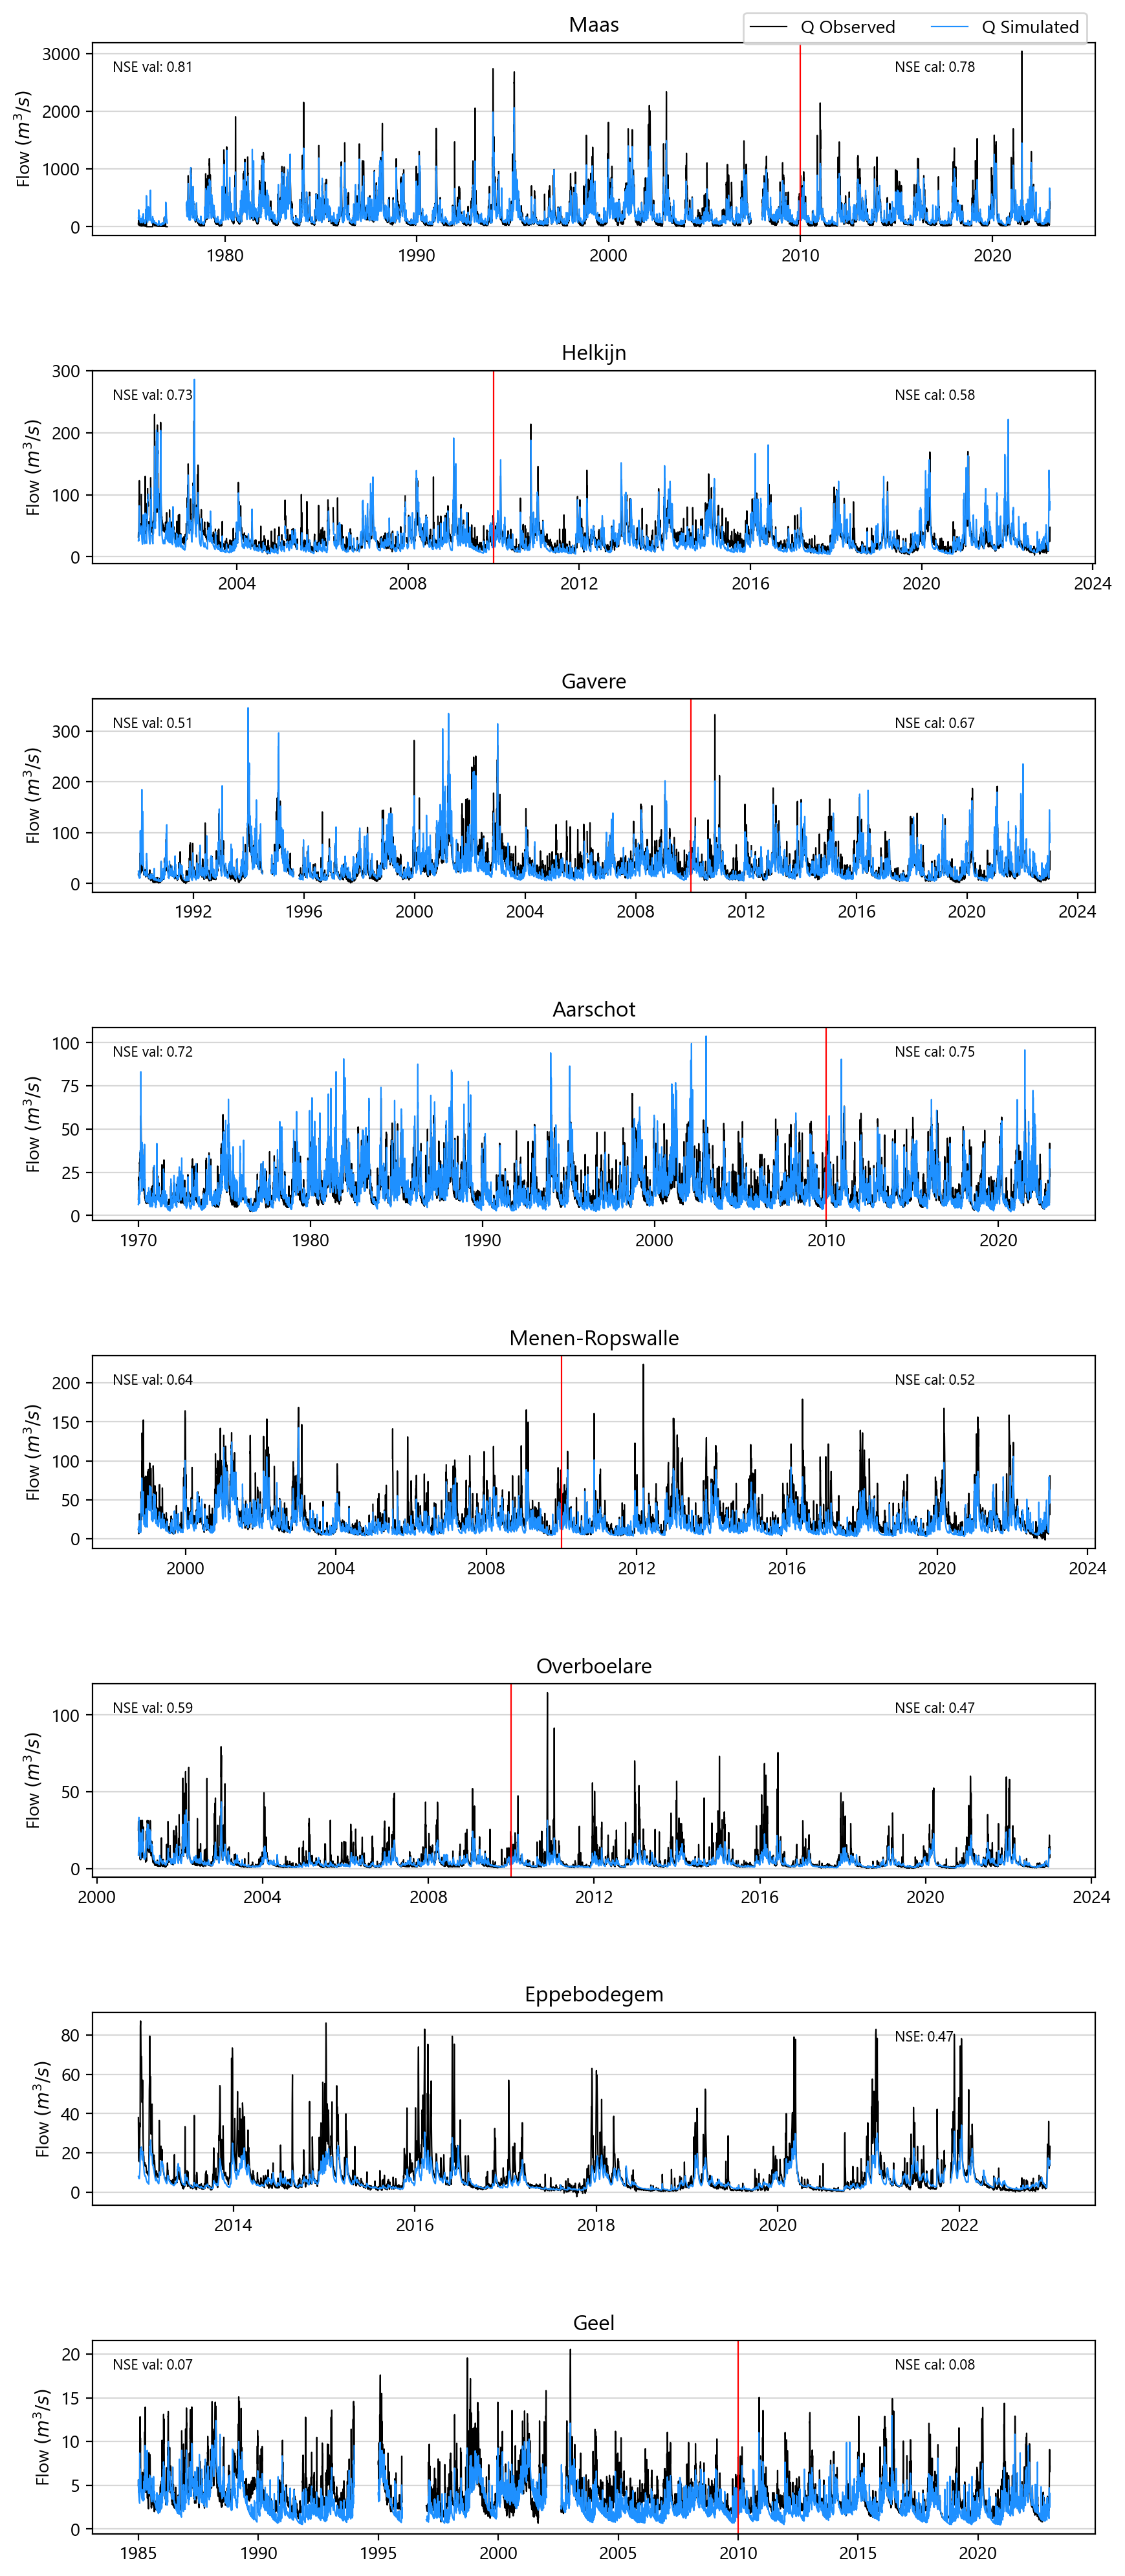

In [104]:
ncols = 1
nrows = len(eval_station)//ncols

fig, _ = plt.subplots(nrows, ncols, figsize=(10, 25), dpi=200)

#space between subplots
plt.subplots_adjust(hspace=0.7)

for stat in eval_station.keys():
    obs_sim = eval_station[stat]
    ax = plt.subplot(nrows, ncols, list(eval_station.keys()).index(stat)+1)
    ax.plot(obs_sim.index, obs_sim['observed'], label='Q Observed', color='black', lw=0.8)
    ax.plot(obs_sim.index, obs_sim['simulated'], label='Q Simulated', color='dodgerblue', lw=0.8)
    #compute nse
    nse_val = nse_values_val[stat]
    nse_cal = nse_values_cal[stat]
    #plot vertical line at the start of the validation period (year 2000)
    # Convert the string date to a datetime object
    if pd.Timestamp('2010-01-01') - obs_sim.index.min() > pd.Timedelta(days=1825):

        vertical_line_date = pd.to_datetime('2010-01-01')
    # Add vertical line at '2000-01-01'
        ax.axvline(x=vertical_line_date, color='red', lw=0.8)  
    if obs_sim.index.min() < pd.Timestamp('2010-01-01'):
            ax.text(0.02, 0.85, f'NSE val: {nse_val}', transform=ax.transAxes, fontsize=8) 
            ax.text(0.8, 0.85, f'NSE cal: {nse_cal}', transform=ax.transAxes, fontsize=8)
    else:
        ax.text(0.8, 0.85, f'NSE: {nse_cal}', transform=ax.transAxes, fontsize=8)
        
    ax.grid(alpha=0.5, axis='y')
    ax.set_ylabel('Flow $(m^{3}/s)$')
    ax.set_title(stat)
plt.legend(loc='best', bbox_to_anchor=(1.0, 13.1), ncol=2);

### Spatial Datasets

#### Soil Moisture

In [44]:
#Define ROI
roi = dict(lat=slice(51.5, 50.0), lon=slice(2.0, 3.5))

#extracting the simulated flow
mhm_sm_ts = mhm_fluxes_mon['SM_L02'].sel(roi).mean(dim=['lat','lon']).to_dataframe()
gleam_sm_ts = gleam_rzsm['SMrz'].sel(roi).mean(dim=['lat','lon']).to_dataframe()

In [ ]:
gleam_sm_ts.index.max(), mhm_sm_ts.index.max()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 3.0))
ax2=ax.twinx()
#mhm soil moisture
ax.plot(mhm_sm_ts['SM_L02'][gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='coral', lw=1.7, label='sm mHM')
ax2.plot(gleam_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='dodgerblue', lw=1.5, label='sm GLEAM', alpha=0.9)
ax.set_ylabel('sm mHM', fontsize=12)
ax2.set_ylabel('sm GLEAM', fontsize=12)
plt.xticks(fontsize=15)
#collect legend handles and labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2, fontsize=13)


In [72]:
#resample to month ends
mhm_monthly_recharge = mhm_fluxes['recharge'].resample(time='ME').sum()
mhm_mon_average_recharge = mhm_monthly_recharge.groupby('time.month').mean(dim='time')
mhm_annual_recharge = mhm_monthly_recharge.groupby('time.year').sum()

In [73]:
mhm_mean_month = mhm_fluxes.groupby('time.month').mean(dim='time')

In [ ]:
mhm_annual_recharge[0].plot() 


### Clip to Belgium

In [67]:
#import rioxarray
#ref: https://gis.stackexchange.com/questions/289775/masking-netcdf-data-using-shapefile-xarray-geopandas
#ref: https://medium.com/@harismushtaq021/clip-netcdf-data-from-shapefile-using-rioxarray-and-geopandas-5e5e5337fdd

data_be = clip_to_region(be_shp, mhm_fluxes)

data_be_monthly = data_be.groupby('time.month').mean(dim='time')

data_gleam_monthly = clip_to_region(be_shp, gleam_rzsm).groupby('time.month').mean(dim='time')

In [ ]:
#plotting the clipped data
#change ccrs.PlateCarree() to ccrs.epsg(4326) for better resolution
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming `clipped`, `be_shp`, and other variables are already defined
layer = 'SWC_L01'

cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6), dpi=150)
vmin, vmax = data_be[layer][5].min(), data_be[layer][5].max()

# Plot the data
im = data_be[layer][5].plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    robust=True,
    add_colorbar=False  # Disable the default colorbar
)

# Add shapefile boundaries
be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add a horizontal colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=20, shrink=1.0)
cbar.set_label(f"{layer} mm", fontsize=12)  # Add a label to the colorbar

# Add latitude and longitude gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5, draw_labels=True)
gl.top_labels = True
gl.right_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.title(" ")
plt.show()


In [ ]:
#plotting the clipped data
#change ccrs.PlateCarree() to ccrs.epsg(4326) for better resolution
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Assuming `clipped`, `be_shp`, and other variables are already defined
layer = 'SMrz'

cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6), dpi=150)
vmin, vmax = data_gleam_monthly[layer][5].min(), data_gleam_monthly[layer][5].max()

# Plot the data
im = data_gleam_monthly[layer][5].plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax,
    add_colorbar=False  # Disable the default colorbar
)

# Add shapefile boundaries
be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add a horizontal colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=20, shrink=1.0)
cbar.set_label('Soil Water Content (SWC)', fontsize=12)  # Add a label to the colorbar

# Add latitude and longitude gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), linestyle='--', alpha=0.5, draw_labels=True)
gl.top_labels = True
gl.right_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.title(" ")
plt.show()


In [ ]:
var = 'SWC_L02'

# Define grid dimensions
nrows = 3
ncols = len(mhm_mean_month.month) // nrows # Dynamic column calculation

fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15, 10), dpi=150)
# Flatten axes for easier indexing
axes = axes.ravel()

    # Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# Calculate uniform vmin and vmax
vmin = data_be_monthly[var].min().values  # Minimum value across all months
vmax = data_be_monthly[var].max().values  # Maximum value across all months

# Plot each month's data
for idx, month in enumerate(mhm_mean_month.month):
    ax = axes[idx]
    im = data_be_monthly[var][month-1].plot(
        ax=ax,
        vmin=vmin,  # Set the minimum value
        vmax=vmax,  # Set the maximum value
        cmap='RdBu',  # Set the colormap
        #transform=ccrs.PlateCarree(),
        #robust=True,
        add_colorbar=False,
    )

    month_name = calendar.month_name[month.values]  # Get the name of the month
    ax.set_title(month_name, fontsize=12)

    # Add shapefile boundaries
    be_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# Add latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), lw=0.2, alpha=0.8, draw_labels=True)
    # Show top labels only on the first row
    gl.top_labels = idx < ncols
    gl.bottom_labels = False

    # Show left labels only on the first column
    gl.left_labels = idx % ncols == 0
    gl.right_labels = False

    # Style grid labels
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #label spacing
    # Style grid labels with spacing adjustments
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    #set xtick labels
    gl.xlocator = mticker.FixedLocator([2, 3, 4, 5,6])
    gl.ylocator = mticker.FixedLocator([50, 51, 52])
     #change frame color
    # Change the frame thickness
    for spine in ax.spines.values():
        spine.set_linewidth(.1)  # Adjust thickness here (e.g., 2 for thicker frames)


# Remove unused subplots if there are more axes than months
for ax in axes[len(mhm_mean_month.month):]:
    ax.remove()

# Add a shared colorbar
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.03])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Soil Water Content (mm)')

plt.show()

#### Evapotranspiration

In [105]:
#select the variable from mHM and do time slice
mHM_ET = mhm_fluxes['aET'].sel(time=slice('2000-01-01', '2023-12-27'))

modis_ET_mon = modis_data_et.resample(time='ME').sum()
mHM_ET_mon = mHM_ET.resample(time='ME').sum()
modis_ET_mon = modis_ET_mon.where(modis_ET_mon > 0, np.nan)
mHM_ET_mon = mHM_ET_mon.where(mHM_ET_mon>0, np.nan)

modis_et_monscaled = modis_ET_mon*0.1

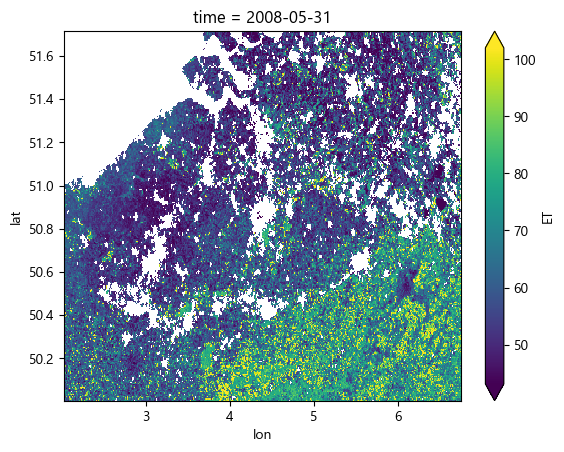

In [106]:
(modis_et_monscaled[100]).plot(robust=True)
plt.show()

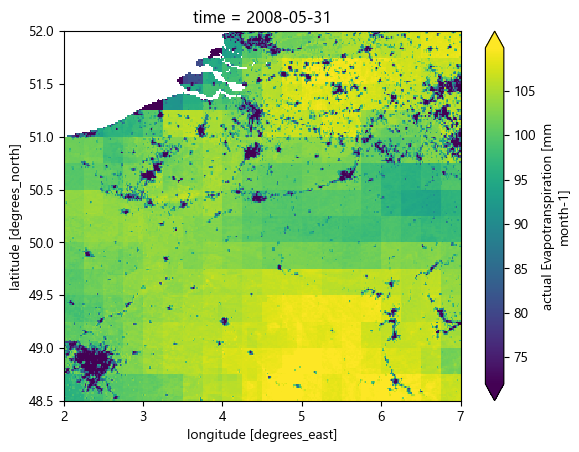

In [107]:
(mHM_ET_mon[100]).plot(robust=True)

#### ET comparison plots

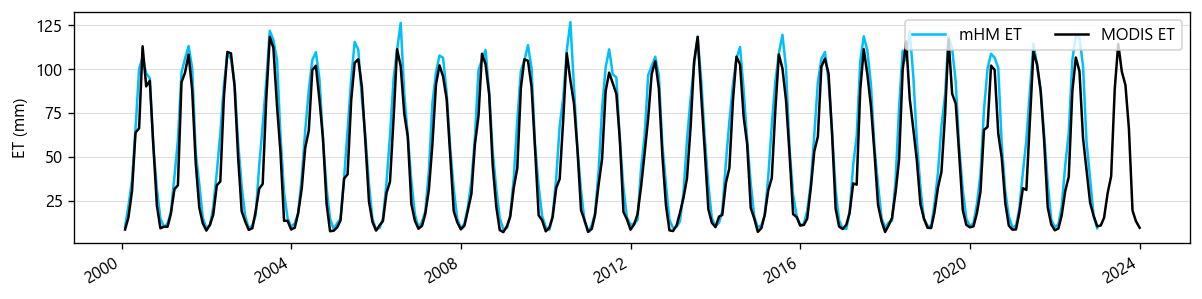

In [115]:
#plot south of belgium
fig, ax = plt.subplots(figsize=(12,2.5), dpi = 120)

mHM_ET_mon.sel(lat=slice(50.6, 50.2), lon=slice(5, 6)).mean(dim=['lat', 'lon']).plot(ax=ax, label = 'mHM ET', color='deepskyblue', lw=1.5);
modis_et_monscaled.sel(lat=slice(50.6, 50.2), lon=slice(5, 6)).mean(dim=['lat', 'lon']).plot(ax=ax, label = 'MODIS ET', color='k');
plt.grid(axis='y', alpha=0.5, lw=0.5)
plt.ylabel('ET (mm)')
plt.xlabel('')
plt.legend(loc='upper right', ncols=2);

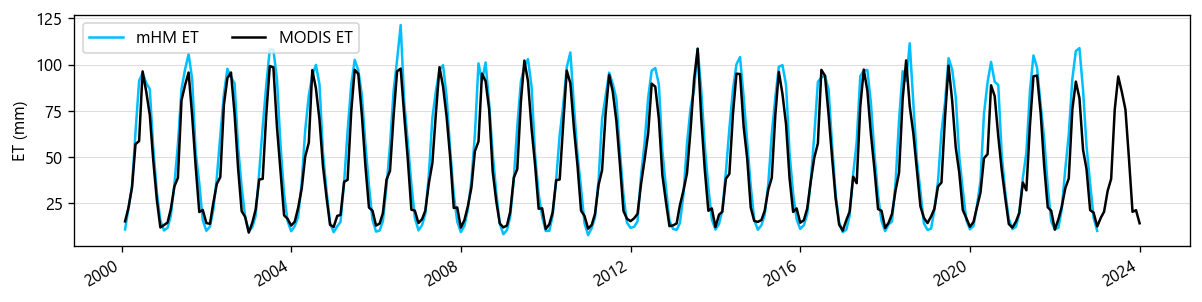

In [114]:
#plot near the coast
fig, ax = plt.subplots(figsize=(12,2.5), dpi = 120)

mHM_ET_mon.sel(lat=slice(51.0, 50.8), lon=slice(2.0, 2.6)).mean(dim=['lat', 'lon']).plot(ax=ax, label = 'mHM ET', c='deepskyblue', lw=1.5);
modis_et_monscaled.sel(lat=slice(51.0, 50.8), lon=slice(2.0, 2.6)).mean(dim=['lat', 'lon']).plot(ax=ax, label = 'MODIS ET', c='k');
plt.grid(axis='y', alpha=0.5, lw=0.5)
plt.ylabel('ET (mm)')
plt.xlabel('')
plt.legend(loc='best', ncols=2);